<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Máster Universitario en Análisis y Visualización de Datos Masivos/ Visual Analytics and Big Data </header1></center>
<center><h2>Modelo predictivo de zonas de Madrid con mayor incidencia de enfermedades respiratorias </header2><center>

Presentado por: Adela Corina Ponce Roman Y Hugo Gómez Bahamonde<br>
Fecha: 04/12/2024

# Importación de librerias necesarias

In [115]:
import pandas as pd
from pandas import read_csv
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metrics import root_mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

plt.style.use('ggplot')
#from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Parte I. Análisis exploratorio

## Cargar el Dataset

 La información del conjunto de datos están relacionados con las defunciones mensualess por enfermedades respiratorias y los niveles de concetración de contaminantes (NOX, SOx, PM<2,5, PM<10, Ozono y benceno) por zonas de Madrid. Los niveles de concentración de contaminantes vienen dados en microgramos por metro cúbico. Se trata de un dataset de formato .csv de 7 variables numéricas y 1 categórica con   

In [8]:
#Código para cargar el Dataset
url = 'https://raw.githubusercontent.com/hgba88/TFM/refs/heads/main/Contaminantes_Muertes.csv'
dataset = pd.read_csv(url, sep=';')

## Descripción de la fuente del Dataset

In [10]:
print(dataset.shape)

(689, 14)


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   _id                                     689 non-null    object 
 1   Mes                                     689 non-null    object 
 2   Magnitud                                689 non-null    object 
 3   Tipo_Estacion                           689 non-null    object 
 4   Estacion                                689 non-null    object 
 5   Zona                                    689 non-null    object 
 6   Concentraciones_medias_mensuales        689 non-null    float64
 7   Muertes_hombre                          689 non-null    int64  
 8   Muertes_mujer                           689 non-null    int64  
 9   Muertes_totales                         689 non-null    int64  
 10  Total_Concentraciones_medias_mensuales  689 non-null    float6

In [12]:
#dataset= dataset.drop(columns=['_id', 'Tipo_Estacion', 'Estacion', 'Concentraciones_medias_mensuales', 'Indice_Calidad_Aire_CAQI', 'Indice_Calidad_Aire_Europeo'], errors='ignore')
dataset= dataset.drop(columns=['_id', 'Tipo_Estacion', 'Estacion','Indice_Calidad_Aire_CAQI', 'Indice_Calidad_Aire_Europeo', 'Umbrales_oms','Muertes_mujer', 'Muertes_hombre','Concentraciones_medias_mensuales' ], errors='ignore')
dataset.head()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
0,2010-01-01,Dióxido de azufre,Oeste,23,8.0
1,2010-01-01,Dióxido de azufre,Interior M30,354,14.5
2,2010-01-01,Dióxido de azufre,Este,28,13.5
3,2010-01-01,Dióxido de azufre,Sur,68,9.0
4,2010-02-01,Dióxido de azufre,Interior M30,312,15.0


In [13]:
#dataset['Magnitud'] = dataset['Magnitud'].map({'Dióxido de azufre': 1, 'Dióxido de nitrógeno': 2, 'Ozono': 3, 'Partículas en suspensión < 10µm': 4, 'Partículas en suspensión < 2,5µm': 5, 'Benceno': 6})
#dataset['Zona'] = dataset['Zona'].map({'Interior M30': 1, 'Este': 2, 'Norte': 3, 'Oeste': 4, 'Sur': 5})

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Mes                                     689 non-null    object 
 1   Magnitud                                689 non-null    object 
 2   Zona                                    689 non-null    object 
 3   Muertes_totales                         689 non-null    int64  
 4   Total_Concentraciones_medias_mensuales  689 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 27.0+ KB


In [15]:
dataset['Mes'] = pd.to_datetime(dataset['Mes'])
dataset['Magnitud'] = pd.Categorical(dataset['Magnitud'])
dataset['Zona'] = pd.Categorical(dataset['Zona'])
dataset['Total_Concentraciones_medias_mensuales'] = dataset['Total_Concentraciones_medias_mensuales'].astype('int64')

In [16]:
# valores del atributo 'umbrales_oms', que será el atributo que usemos para predecir y 
# y el numero de instancias que tienen ese valor del atributo 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Mes                                     689 non-null    datetime64[ns]
 1   Magnitud                                689 non-null    category      
 2   Zona                                    689 non-null    category      
 3   Muertes_totales                         689 non-null    int64         
 4   Total_Concentraciones_medias_mensuales  689 non-null    int64         
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 18.0 KB


In [17]:
# No hay valores desconocidos en los atributos del dataset
dataset.isna().sum()

Mes                                       0
Magnitud                                  0
Zona                                      0
Muertes_totales                           0
Total_Concentraciones_medias_mensuales    0
dtype: int64

In [18]:
#se dividie el dataset en varios datasets por diferentes zonas
dataset_M30 = dataset[dataset['Zona'] == 'Interior M30']
dataset_Norte = dataset[dataset['Zona'] == 'Norte']
dataset_Sur = dataset[dataset['Zona'] == 'Sur']
dataset_Este = dataset[dataset['Zona'] == 'Este']
dataset_Oeste = dataset[dataset['Zona'] == 'Oeste']
 

In [19]:
#Se obienen los diferentes valores del atributo Total_Concentraciones_medias_mensuales y la frecuencia de cada uno de ellos en las instancias
print(dataset_M30.groupby('Total_Concentraciones_medias_mensuales').size())

Total_Concentraciones_medias_mensuales
0     29
1     23
2      1
3      2
4      3
      ..
71     3
73     2
76     1
78     1
79     1
Length: 74, dtype: int64


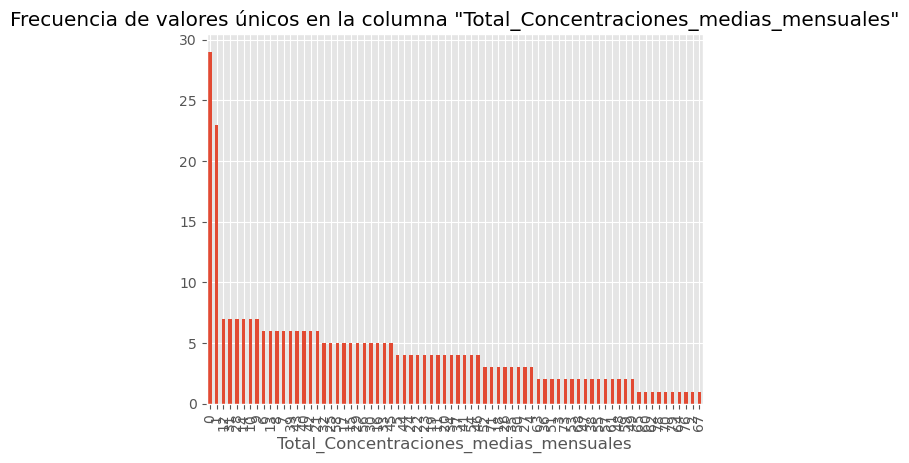

In [20]:
class_counts = dataset_M30['Total_Concentraciones_medias_mensuales'].value_counts()
# Crear el gráfico de barras
class_counts.plot(kind='bar')
# Agregar un título
plt.title('Frecuencia de valores únicos en la columna "Total_Concentraciones_medias_mensuales"')
# Mostrar el gráfico
plt.show() 

In [21]:
#Se obienen los diferentes valores del atributo Total_Concentraciones_medias_mensuales y la frecuencia de cada uno de ellos en las instancias
print(dataset_Norte.groupby('Total_Concentraciones_medias_mensuales').size())

Total_Concentraciones_medias_mensuales
0     2
1     2
7     1
9     2
10    4
     ..
78    1
80    2
81    3
82    1
86    1
Length: 71, dtype: int64


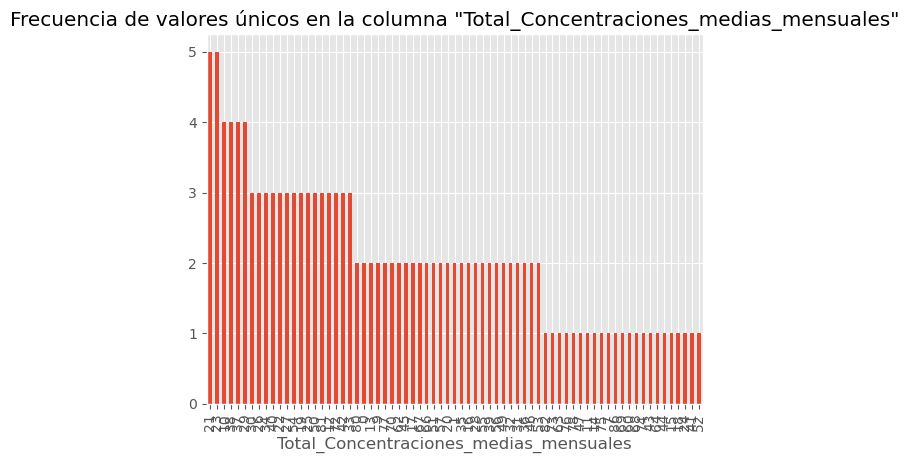

In [22]:
class_counts = dataset_Norte['Total_Concentraciones_medias_mensuales'].value_counts()
# Crear el gráfico de barras
class_counts.plot(kind='bar')
# Agregar un título
plt.title('Frecuencia de valores únicos en la columna "Total_Concentraciones_medias_mensuales"')
# Mostrar el gráfico
plt.show() 

In [23]:
#Se obienen los diferentes valores del atributo Total_Concentraciones_medias_mensuales y la frecuencia de cada uno de ellos en las instancias
print(dataset_Este.groupby('Total_Concentraciones_medias_mensuales').size())

Total_Concentraciones_medias_mensuales
1     1
3     1
5     1
6     2
11    1
12    1
13    2
15    1
18    1
19    1
20    1
22    1
23    1
24    3
25    1
26    3
27    1
28    1
29    2
30    2
33    2
34    1
36    1
37    1
38    2
39    1
40    1
41    2
42    1
43    1
44    1
45    2
46    1
47    1
48    1
49    1
51    2
52    1
53    1
55    1
57    1
58    1
59    1
60    1
61    1
62    2
63    1
65    1
66    1
67    1
68    1
71    1
73    1
74    1
76    1
77    1
79    1
80    1
83    1
90    1
dtype: int64


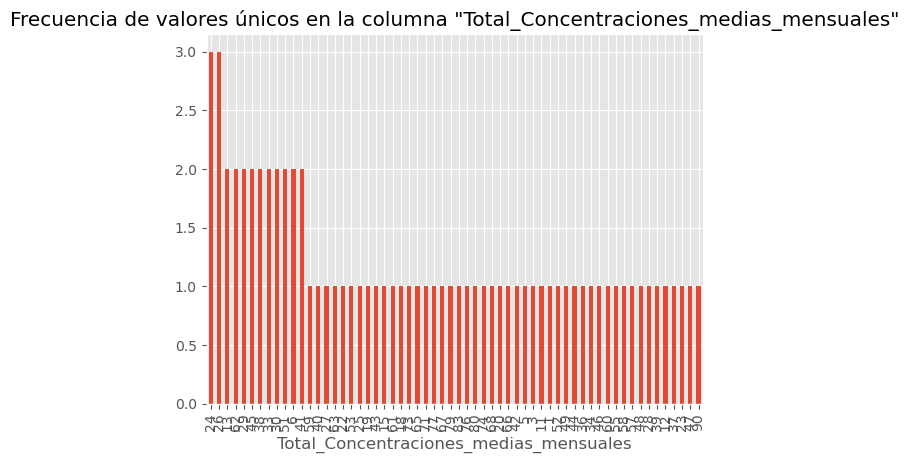

In [24]:
class_counts = dataset_Este['Total_Concentraciones_medias_mensuales'].value_counts()
# Crear el gráfico de barras
class_counts.plot(kind='bar')
# Agregar un título
plt.title('Frecuencia de valores únicos en la columna "Total_Concentraciones_medias_mensuales"')
# Mostrar el gráfico
plt.show() 

In [25]:
#Se obienen los diferentes valores del atributo Total_Concentraciones_medias_mensuales y la frecuencia de cada uno de ellos en las instancias
print(dataset_Oeste.groupby('Total_Concentraciones_medias_mensuales').size())

Total_Concentraciones_medias_mensuales
0     5
1     1
2     1
8     1
11    1
15    1
16    1
17    2
18    2
19    2
20    2
21    1
22    2
23    2
24    1
25    1
26    1
27    2
28    1
30    1
34    1
36    1
37    2
47    1
55    1
60    1
61    1
64    1
65    1
66    1
67    1
68    1
69    1
71    1
72    1
75    2
76    1
77    1
81    1
82    1
83    1
84    2
85    1
86    1
87    1
88    1
89    1
92    1
dtype: int64


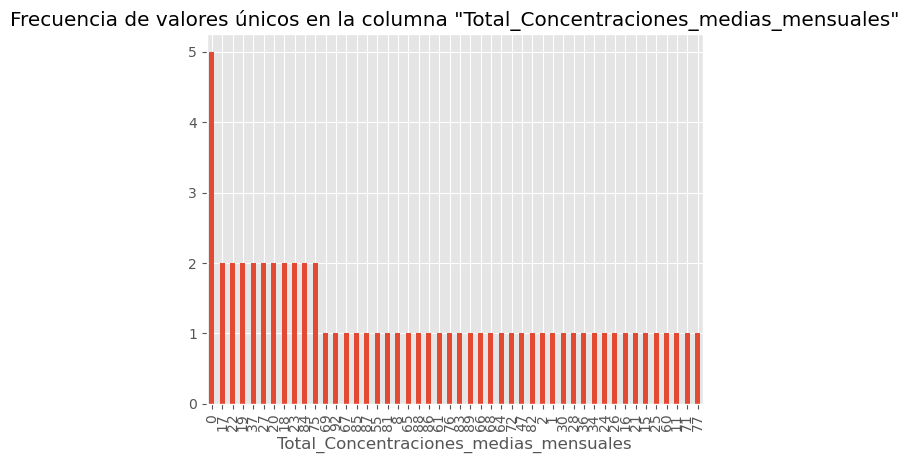

In [26]:
class_counts = dataset_Oeste['Total_Concentraciones_medias_mensuales'].value_counts()
# Crear el gráfico de barras
class_counts.plot(kind='bar')
# Agregar un título
plt.title('Frecuencia de valores únicos en la columna "Total_Concentraciones_medias_mensuales"')
# Mostrar el gráfico
plt.show() 

In [27]:
#Se obienen los diferentes valores del atributo Total_Concentraciones_medias_mensuales y la frecuencia de cada uno de ellos en las instancias
print(dataset_Sur.groupby('Total_Concentraciones_medias_mensuales').size())

Total_Concentraciones_medias_mensuales
0     2
1     2
2     2
3     1
4     2
8     1
9     1
11    1
14    2
16    1
17    1
18    1
27    1
29    1
31    2
32    3
33    1
34    2
35    2
36    1
38    1
39    1
40    1
42    1
43    1
44    2
45    1
46    1
47    2
48    2
50    3
51    1
52    2
53    1
54    2
55    1
56    1
57    1
58    1
59    2
60    1
62    1
63    2
64    2
65    2
66    2
67    2
68    1
69    3
70    2
71    1
73    1
74    2
75    1
76    1
77    1
78    2
80    1
dtype: int64


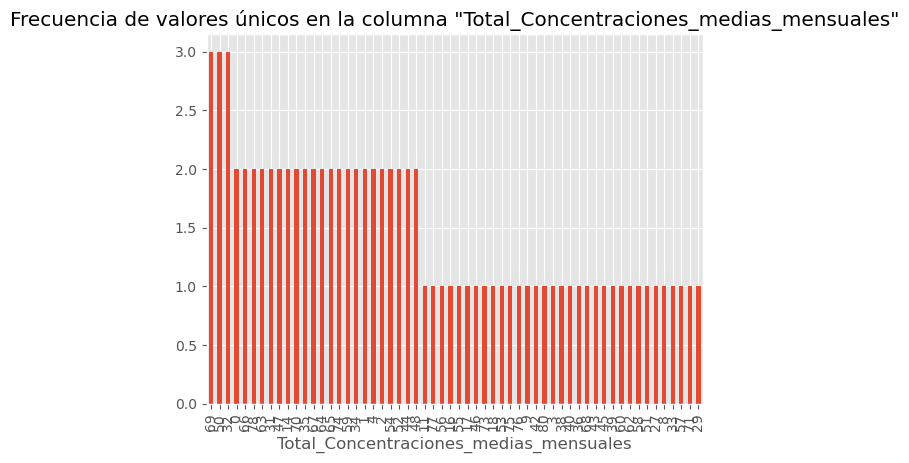

In [28]:
class_counts = dataset_Sur  ['Total_Concentraciones_medias_mensuales'].value_counts()
# Crear el gráfico de barras
class_counts.plot(kind='bar')
# Agregar un título
plt.title('Frecuencia de valores únicos en la columna "Total_Concentraciones_medias_mensuales"')
# Mostrar el gráfico
plt.show() 

In [29]:
#valores 0 reemplazamos con la media de la columna
media_M30 = dataset_M30['Total_Concentraciones_medias_mensuales'][dataset_M30['Total_Concentraciones_medias_mensuales'] != 0].mean()
dataset_M30['Total_Concentraciones_medias_mensuales'] = dataset_M30['Total_Concentraciones_medias_mensuales'].replace(0, media_M30)

media_Norte = dataset_Norte['Total_Concentraciones_medias_mensuales'][dataset_Norte['Total_Concentraciones_medias_mensuales'] != 0].mean()
dataset_Norte['Total_Concentraciones_medias_mensuales'] = dataset_Norte['Total_Concentraciones_medias_mensuales'].replace(0, media_Norte )

media_Sur = dataset_Sur['Total_Concentraciones_medias_mensuales'][dataset_Sur['Total_Concentraciones_medias_mensuales'] != 0].mean()
dataset_Sur['Total_Concentraciones_medias_mensuales'] = dataset_Sur['Total_Concentraciones_medias_mensuales'].replace(0, media_Sur)

media_Este = dataset_Este['Total_Concentraciones_medias_mensuales'][dataset_Este['Total_Concentraciones_medias_mensuales'] != 0].mean()
dataset_Este['Total_Concentraciones_medias_mensuales'] = dataset_Este['Total_Concentraciones_medias_mensuales'].replace(0, media_Este)

media_Oeste = dataset_Oeste['Total_Concentraciones_medias_mensuales'][dataset_Oeste['Total_Concentraciones_medias_mensuales'] != 0].mean()
dataset_Oeste['Total_Concentraciones_medias_mensuales'] = dataset_Oeste['Total_Concentraciones_medias_mensuales'].replace(0, media_Oeste)

In [30]:
dataset_M30.head()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
1,2010-01-01,Dióxido de azufre,Interior M30,354,14.0
4,2010-02-01,Dióxido de azufre,Interior M30,312,15.0
6,2010-04-01,Dióxido de azufre,Interior M30,314,10.0
9,2010-05-01,Dióxido de azufre,Interior M30,311,9.0
12,2010-06-01,Dióxido de azufre,Interior M30,285,7.0


In [31]:
dataset_M30.tail()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
684,2019-04-01,Benceno,Interior M30,321,28.824138
685,2019-10-01,Benceno,Interior M30,344,28.824138
686,2020-04-01,Benceno,Interior M30,1416,28.824138
687,2021-07-01,Benceno,Interior M30,354,28.824138
688,2021-09-01,Benceno,Interior M30,225,28.824138


In [32]:
dataset_Norte.head()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
10,2010-05-01,Dióxido de azufre,Norte,13,10.0
13,2010-06-01,Dióxido de azufre,Norte,11,7.0
20,2010-12-01,Dióxido de azufre,Norte,15,12.0
44,2016-01-01,Dióxido de azufre,Norte,19,16.0
48,2019-01-01,Dióxido de azufre,Norte,23,14.0


In [33]:
dataset_Norte.tail()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
603,2021-05-01,Partículas en suspensión < 10µm,Norte,13,13.000000
626,2010-01-01,Benceno,Norte,15,39.609589
630,2010-02-01,Benceno,Norte,13,39.609589
669,2015-01-01,Benceno,Norte,30,1.000000
674,2015-10-01,Benceno,Norte,20,1.000000


In [34]:
dataset_Este.head()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
2,2010-01-01,Dióxido de azufre,Este,28,13
5,2010-02-01,Dióxido de azufre,Este,25,13
7,2010-04-01,Dióxido de azufre,Este,24,12
14,2010-06-01,Dióxido de azufre,Este,23,6
16,2010-07-01,Dióxido de azufre,Este,25,5


In [35]:
dataset_Este.tail()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
427,2013-07-01,Ozono,Este,29,83
440,2014-05-01,Ozono,Este,31,76
444,2014-06-01,Ozono,Este,31,80
451,2014-08-01,Ozono,Este,29,74
465,2015-06-01,Ozono,Este,33,90


In [36]:
dataset_Oeste.head()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
0,2010-01-01,Dióxido de azufre,Oeste,23,8.000000
8,2010-05-01,Dióxido de azufre,Oeste,19,11.000000
24,2011-10-01,Dióxido de azufre,Oeste,22,2.000000
32,2012-10-01,Dióxido de azufre,Oeste,23,1.000000
51,2021-01-01,Dióxido de azufre,Oeste,29,46.526316


In [37]:
dataset_Oeste.tail()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
524,2021-07-01,Ozono,Oeste,31,77.000000
625,2010-01-01,Benceno,Oeste,23,46.526316
629,2010-02-01,Benceno,Oeste,19,46.526316
639,2010-08-01,Benceno,Oeste,19,46.526316
665,2014-01-01,Benceno,Oeste,30,46.526316


In [38]:
dataset_Sur.head()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
3,2010-01-01,Dióxido de azufre,Sur,68,9.0
11,2010-05-01,Dióxido de azufre,Sur,60,8.0
17,2010-09-01,Dióxido de azufre,Sur,53,3.0
18,2010-10-01,Dióxido de azufre,Sur,59,4.0
30,2012-04-01,Dióxido de azufre,Sur,72,2.0


In [39]:
dataset_Sur.tail()

,Mes,Magnitud,Zona,Muertes_totales,Total_Concentraciones_medias_mensuales
627,2010-01-01,Benceno,Sur,68,2.000000
631,2010-02-01,Benceno,Sur,61,1.000000
633,2010-03-01,Benceno,Sur,59,1.000000
635,2010-04-01,Benceno,Sur,61,46.059524
637,2010-07-01,Benceno,Sur,62,46.059524


In [40]:
print(dataset_M30.groupby('Muertes_totales').size())

Muertes_totales
175     1
225     2
242     1
247     2
249     1
       ..
510     2
524     1
535     2
567     1
1416    3
Length: 90, dtype: int64


Text(0.5, 1.0, ' Evolución Muertes totales - Interior M30 ')

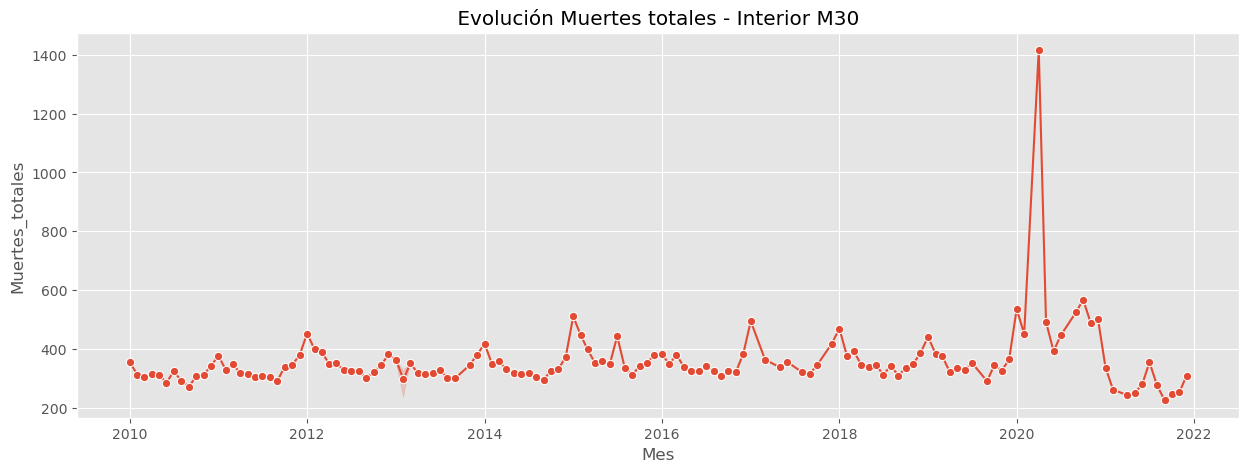

In [41]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_M30, x='Mes', y='Muertes_totales', marker='o')
plt.title(' Evolución Muertes totales - Interior M30 ')

Text(0.5, 1.0, 'Evolución Muertes totales - Norte')

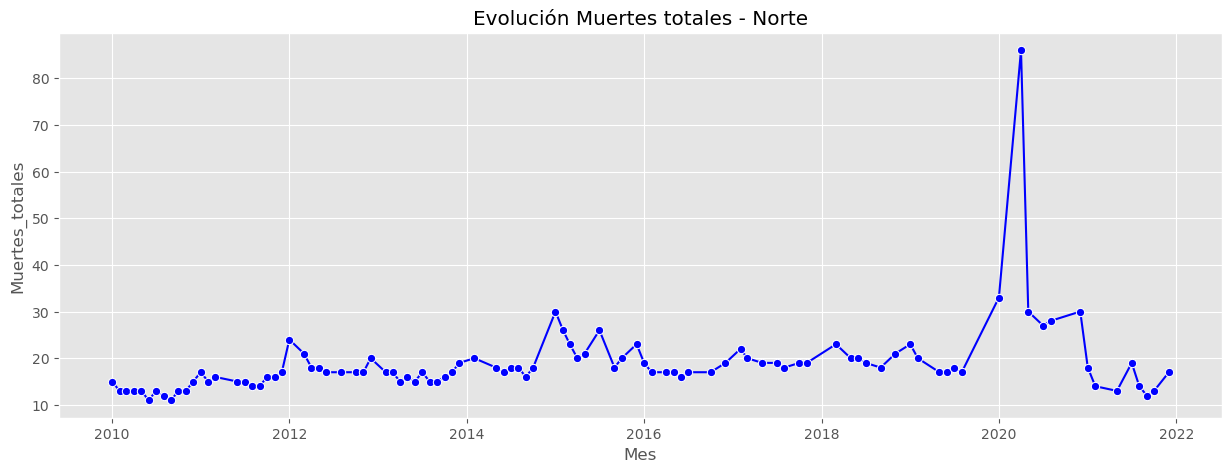

In [42]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Norte, x='Mes', y='Muertes_totales',color='blue', marker='o')
plt.title('Evolución Muertes totales - Norte')

Text(0.5, 1.0, 'Evolución Muertes totales - Oeste')

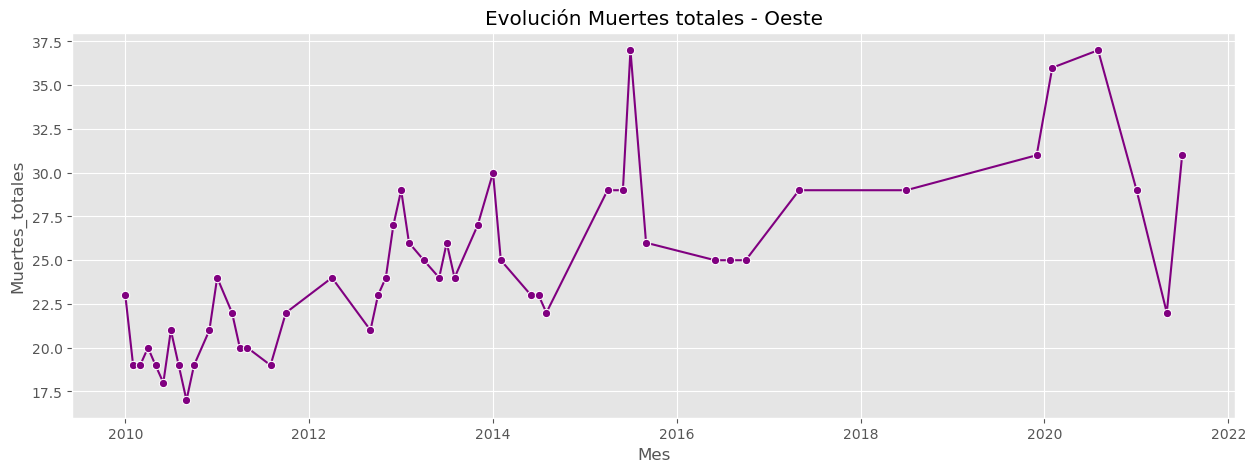

In [43]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Oeste, x='Mes', y='Muertes_totales',color='purple', marker='o')
plt.title('Evolución Muertes totales - Oeste')

Text(0.5, 1.0, ' Evolución Muertes totales - Este ')

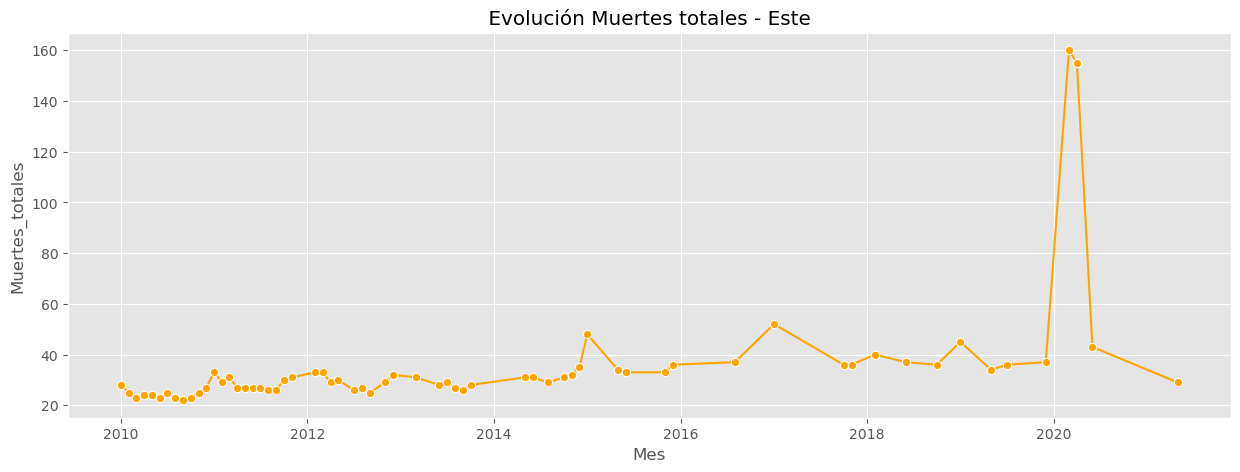

In [44]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Este, x='Mes', y='Muertes_totales',color='orange', marker='o')
plt.title(' Evolución Muertes totales - Este ')

Text(0.5, 1.0, ' Evolución Muertes totales - Sur')

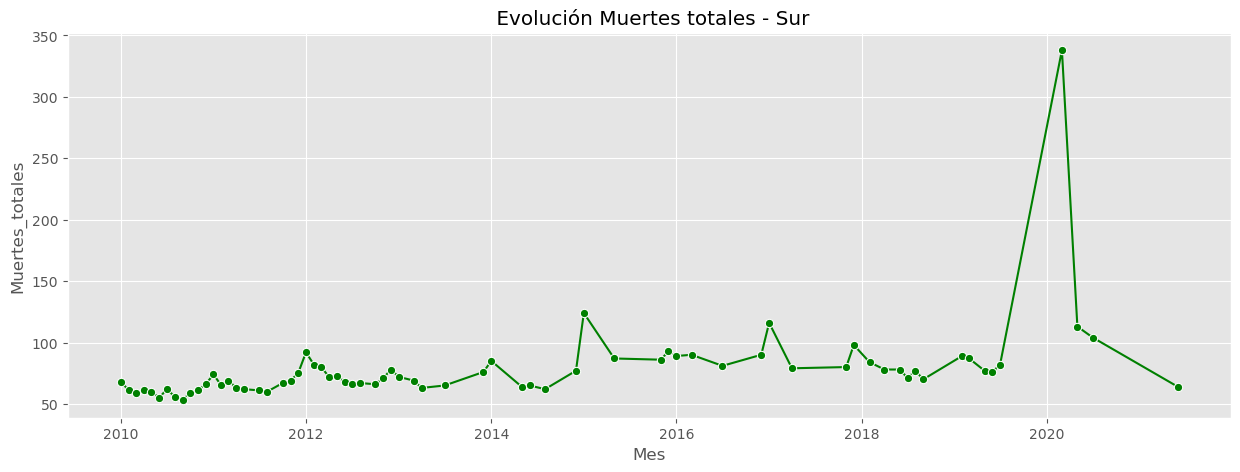

In [45]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Sur, x='Mes', y='Muertes_totales',color='green', marker='o')
plt.title(' Evolución Muertes totales - Sur')

Text(0.5, 1.0, 'Evolución Niveles de Concentraciones medias mensuales - Interior M30')

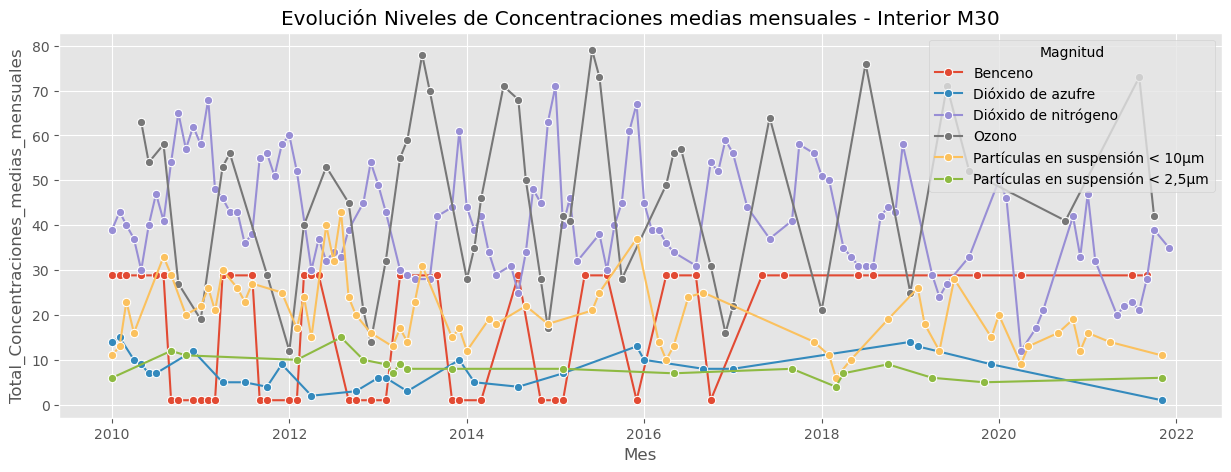

In [46]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_M30, x='Mes', y='Total_Concentraciones_medias_mensuales', hue='Magnitud', marker='o')
plt.title( 'Evolución Niveles de Concentraciones medias mensuales - Interior M30')

Text(0.5, 1.0, 'Evolución Niveles de Concentraciones medias mensuales - Norte')

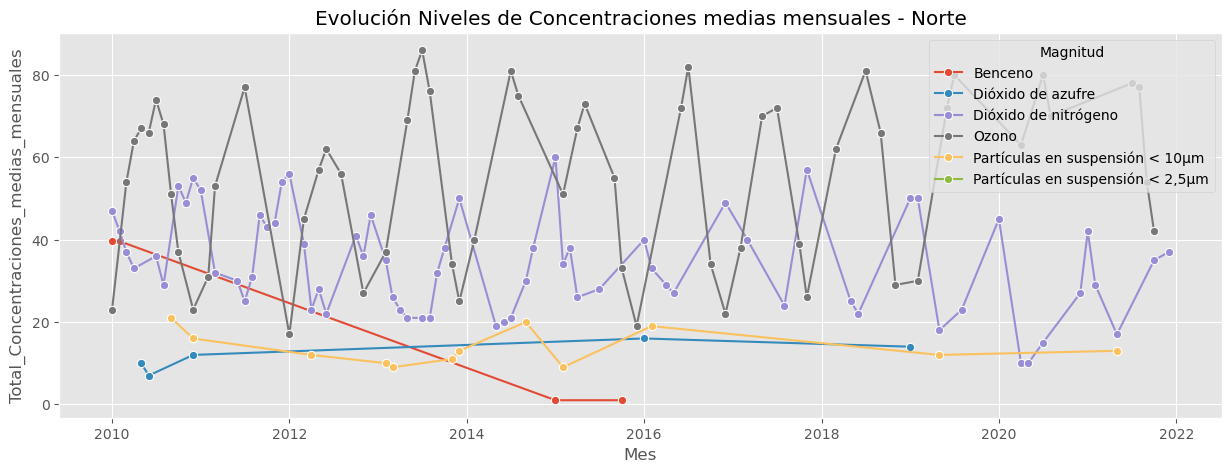

In [47]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Norte, x='Mes', y='Total_Concentraciones_medias_mensuales', hue='Magnitud', marker='o')
plt.title('Evolución Niveles de Concentraciones medias mensuales - Norte')

Text(0.5, 1.0, 'Evolución Niveles de Concentraciones medias mensuales - Sur')

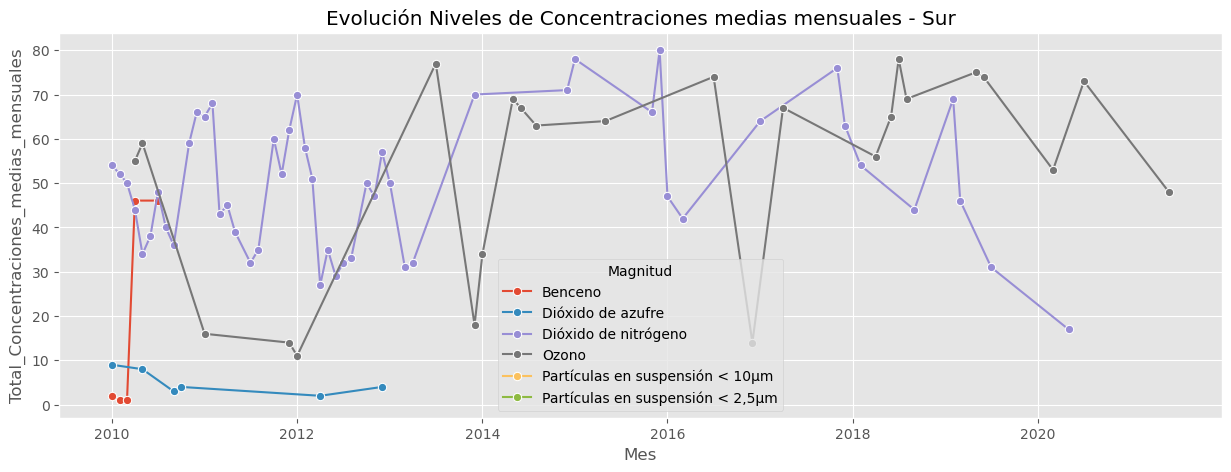

In [48]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Sur, x='Mes', y='Total_Concentraciones_medias_mensuales', hue='Magnitud', marker='o')
plt.title('Evolución Niveles de Concentraciones medias mensuales - Sur')

Text(0.5, 1.0, 'Evolución Niveles de Concentraciones medias mensuales - Este')

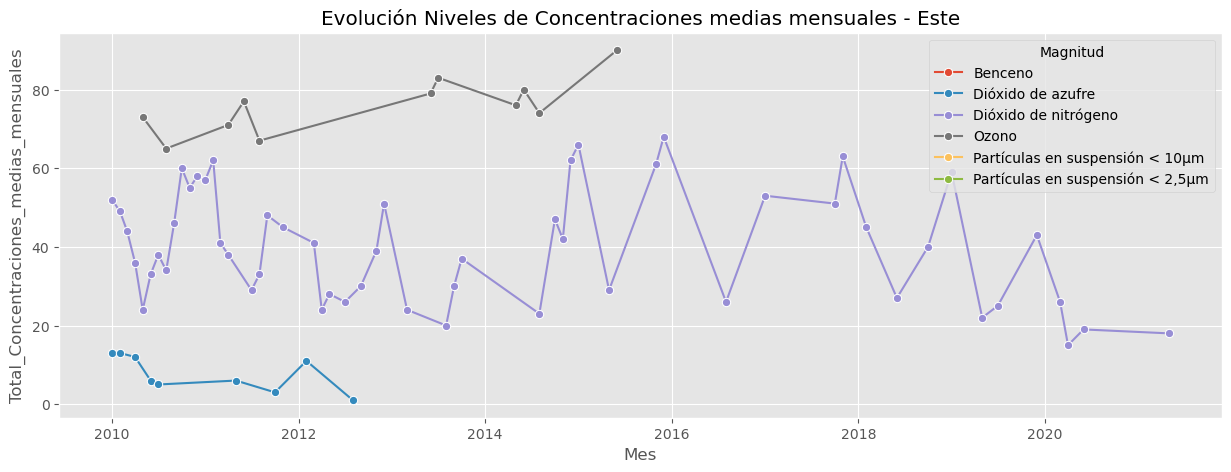

In [49]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Este, x='Mes', y='Total_Concentraciones_medias_mensuales', hue='Magnitud', marker='o')
plt.title('Evolución Niveles de Concentraciones medias mensuales - Este')

Text(0.5, 1.0, 'Evolución Niveles de Concentraciones medias mensuales - Oeste')

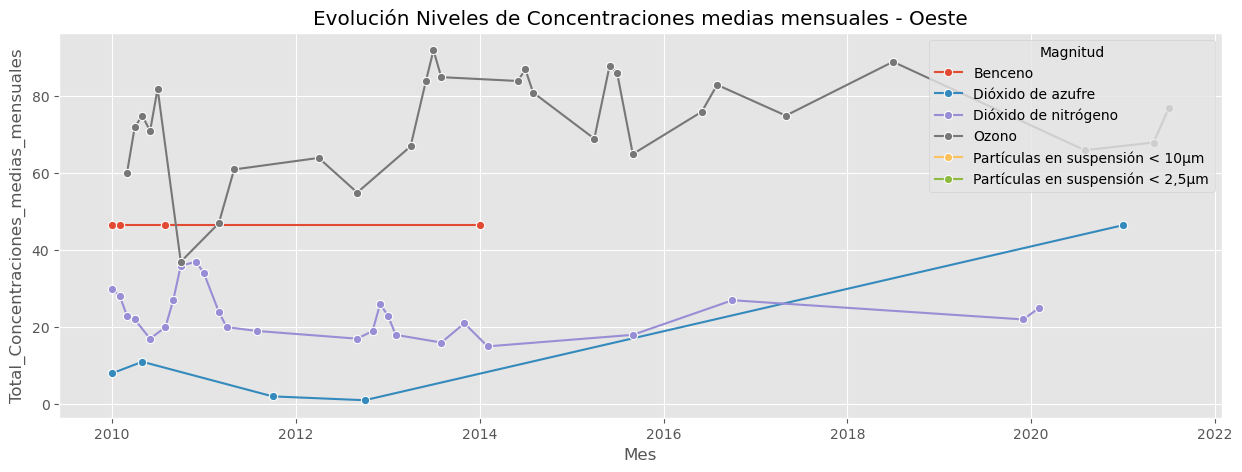

In [50]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dataset_Oeste, x='Mes', y='Total_Concentraciones_medias_mensuales', hue='Magnitud', marker='o')
plt.title('Evolución Niveles de Concentraciones medias mensuales - Oeste')

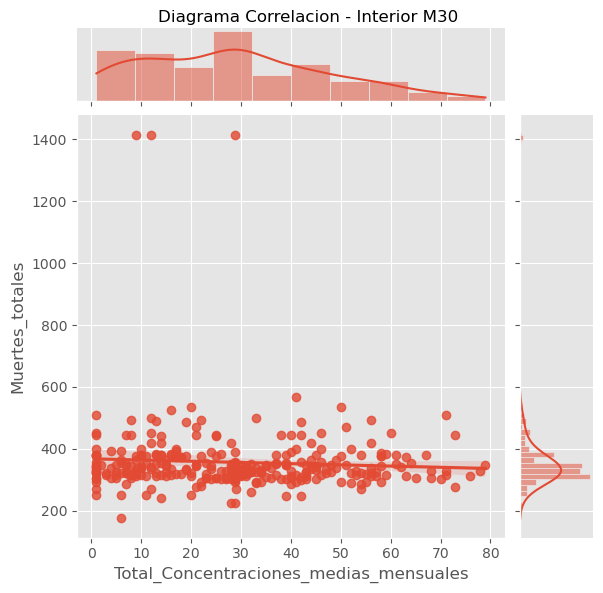

In [51]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_M30,kind='reg');
plt.suptitle("Diagrama Correlacion - Interior M30")
plt.subplots_adjust(top=0.95) 

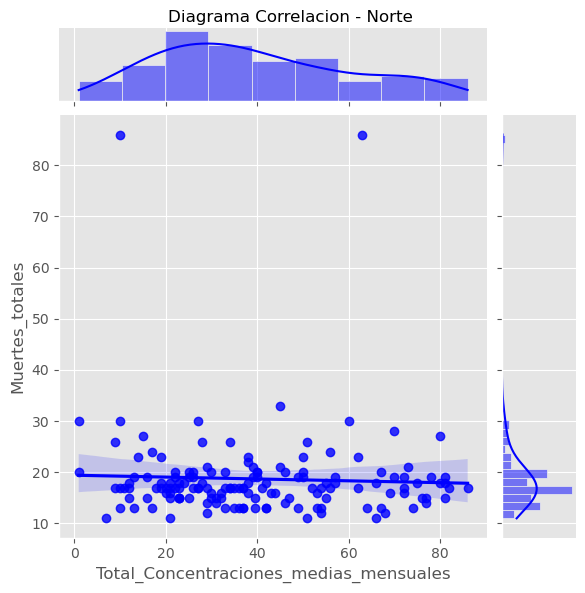

In [52]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Norte,color='blue',kind='reg');
plt.suptitle("Diagrama Correlacion - Norte")
plt.subplots_adjust(top=0.95) 

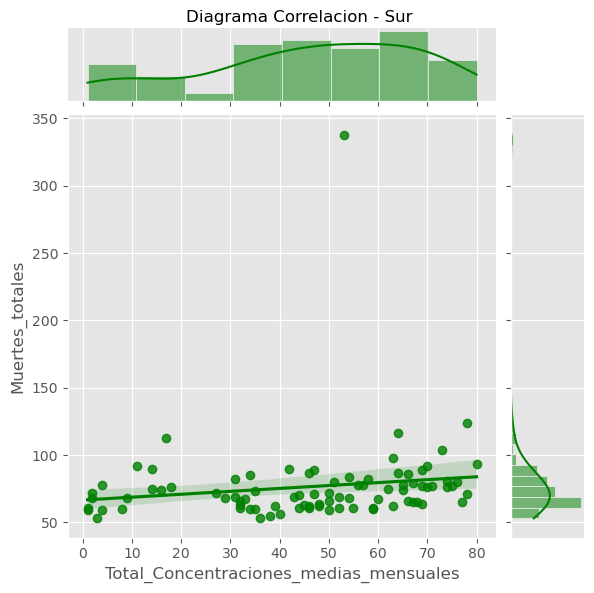

In [53]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Sur,color='green',kind='reg');
plt.suptitle("Diagrama Correlacion - Sur")
plt.subplots_adjust(top=0.95) 

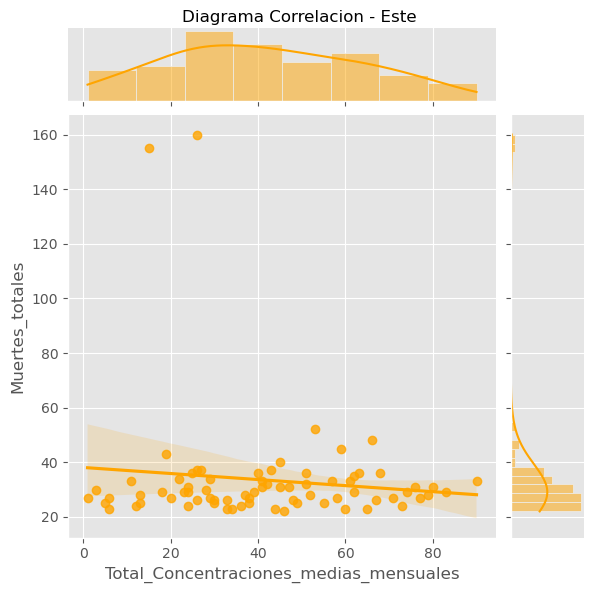

In [54]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Este,color='orange',kind='reg');
plt.suptitle("Diagrama Correlacion - Este")
plt.subplots_adjust(top=0.95) 

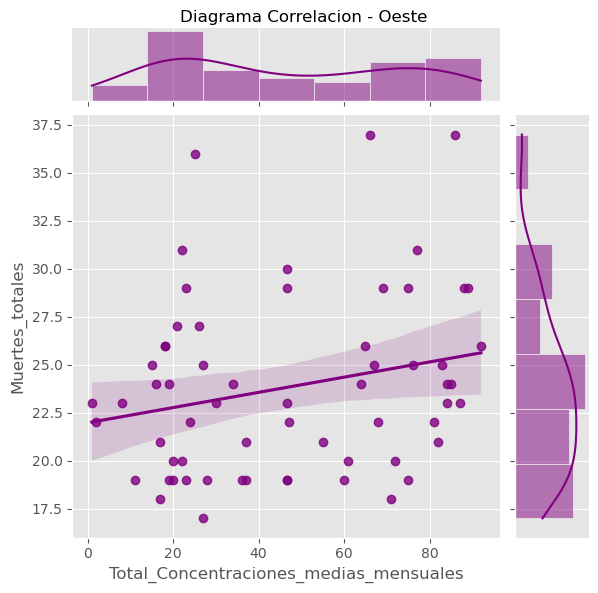

In [55]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Oeste,color='purple',kind='reg');
plt.suptitle("Diagrama Correlacion - Oeste")
plt.subplots_adjust(top=0.95) 

(0.0, 600.0)

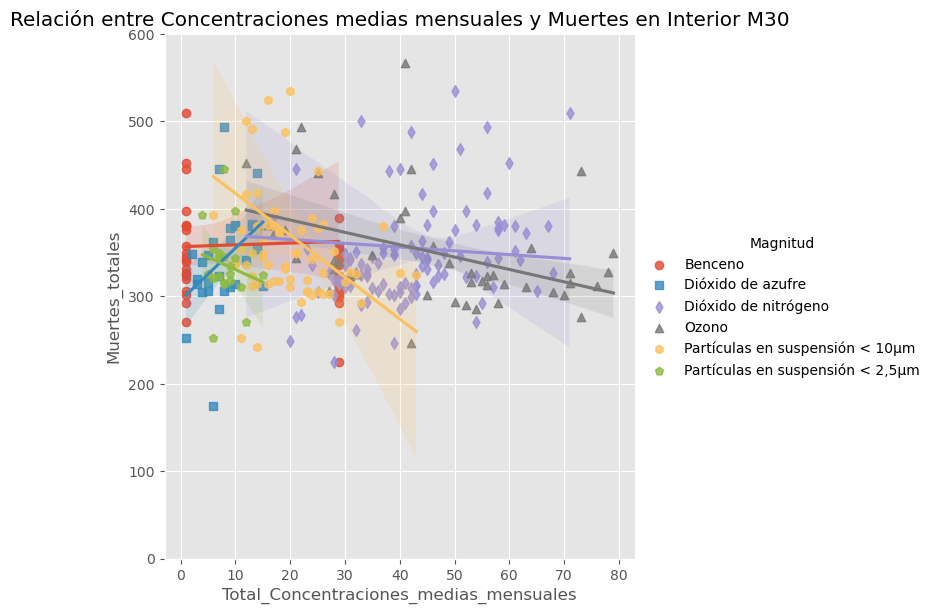

In [56]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_M30, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Interior M30')
plt.ylim(0, 600)

(0.0, 40.0)

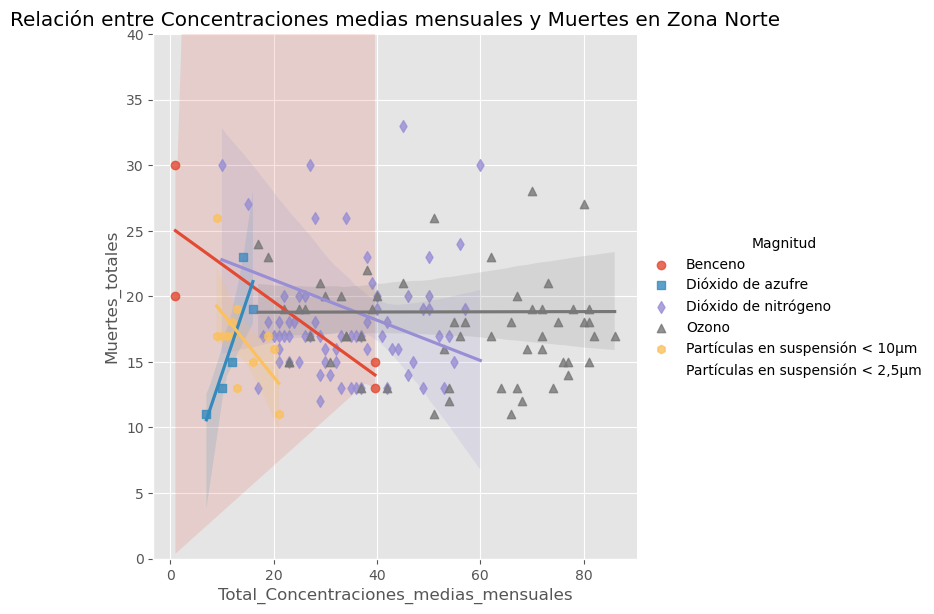

In [57]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Norte, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Norte')
plt.ylim(0, 40)

(0.0, 150.0)

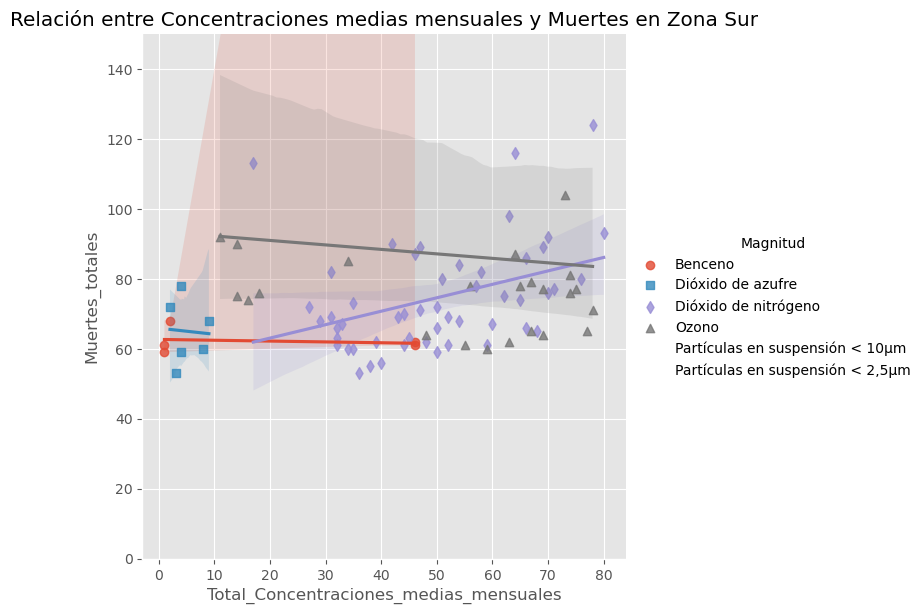

In [58]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Sur, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Sur')
plt.ylim(0, 150)

(0.0, 60.0)

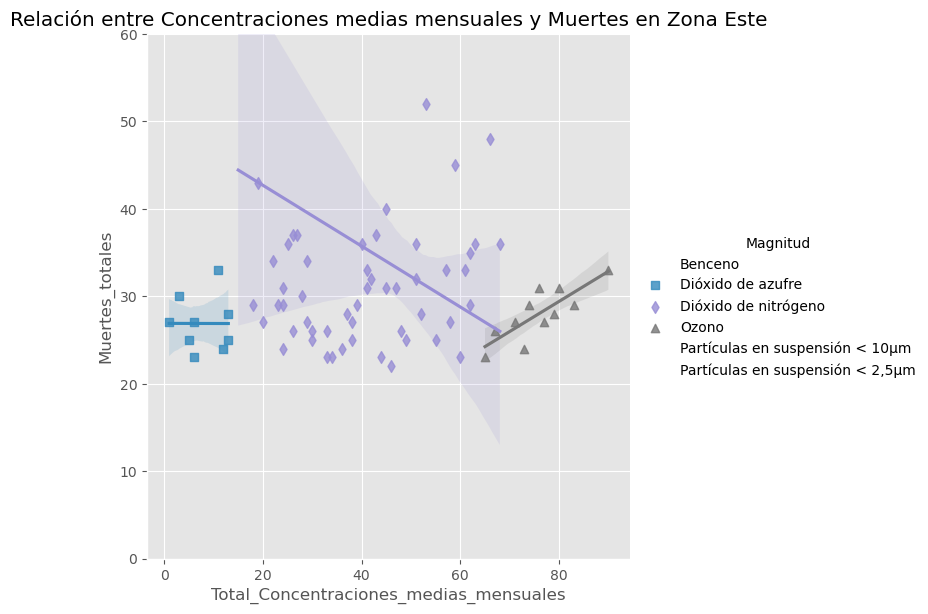

In [59]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Este, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Este')
plt.ylim(0, 60)

(0.0, 50.0)

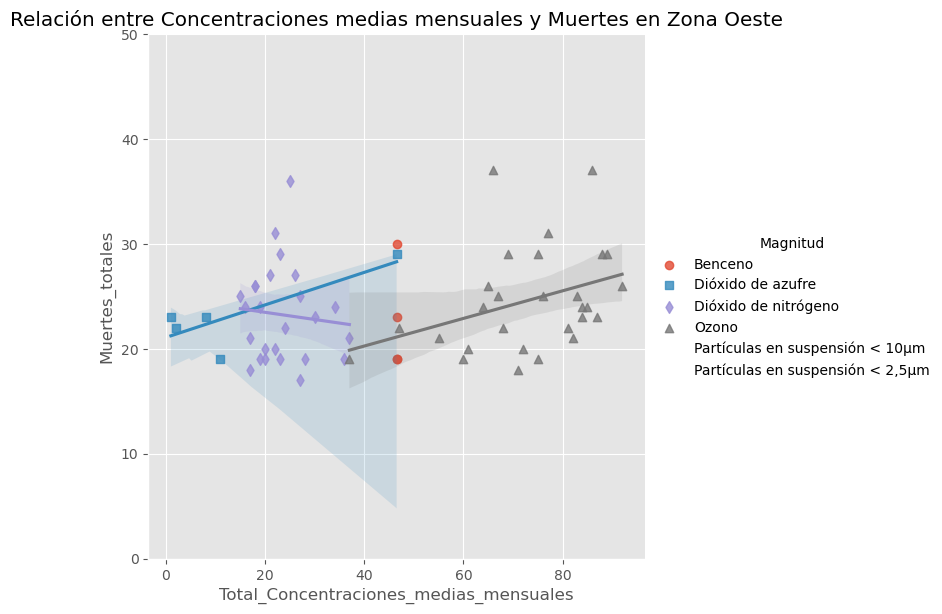

In [60]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Oeste, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Oeste')
plt.ylim(0, 50)

In [61]:
#dataset sin 2020 debido al covid
fecha_inicio = pd.Timestamp('2020-01-01')
fecha_fin = pd.Timestamp('2020-12-01')

# Eliminar filas donde la fecha está dentro del rango
dataset_M30_wo2020 = dataset_M30[~((dataset_M30['Mes'] >= fecha_inicio) & (dataset_M30['Mes'] <= fecha_fin))]
dataset_Norte_wo2020 = dataset_Norte[~((dataset_Norte['Mes'] >= fecha_inicio) & (dataset_Norte['Mes'] <= fecha_fin))]
dataset_Sur_wo2020= dataset_Sur[~((dataset_Sur['Mes'] >= fecha_inicio) & (dataset_Sur['Mes'] <= fecha_fin))]
dataset_Este_wo2020= dataset_Este[~((dataset_Este['Mes'] >= fecha_inicio) & (dataset_Este['Mes'] <= fecha_fin))]
dataset_Oeste_wo2020= dataset_Oeste[~((dataset_Oeste['Mes'] >= fecha_inicio) & (dataset_Oeste['Mes'] <= fecha_fin))]

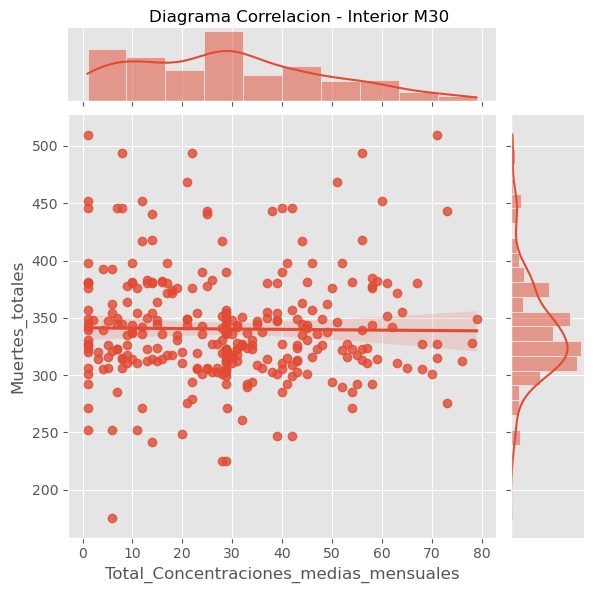

In [62]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_M30_wo2020,kind='reg');
plt.suptitle("Diagrama Correlacion - Interior M30")
plt.subplots_adjust(top=0.95) 

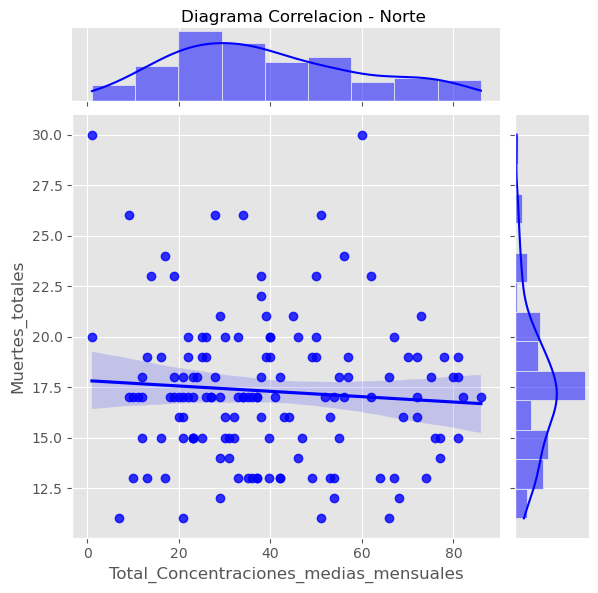

In [63]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Norte_wo2020,color='blue',kind='reg');
plt.suptitle("Diagrama Correlacion - Norte")
plt.subplots_adjust(top=0.95) 

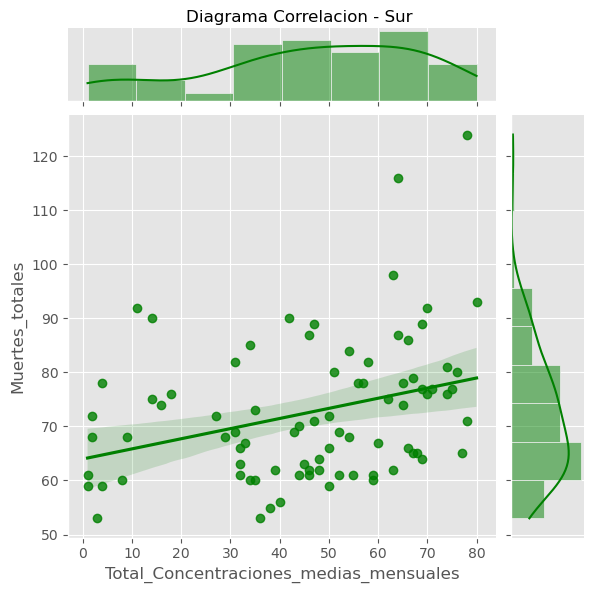

In [64]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Sur_wo2020,color='green',kind='reg');
plt.suptitle("Diagrama Correlacion - Sur")
plt.subplots_adjust(top=0.95) 

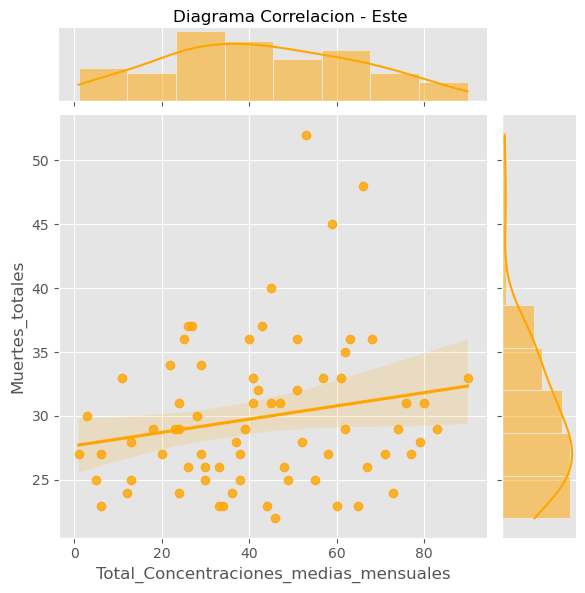

In [65]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Este_wo2020,color='orange',kind='reg');
plt.suptitle("Diagrama Correlacion - Este")
plt.subplots_adjust(top=0.95) 

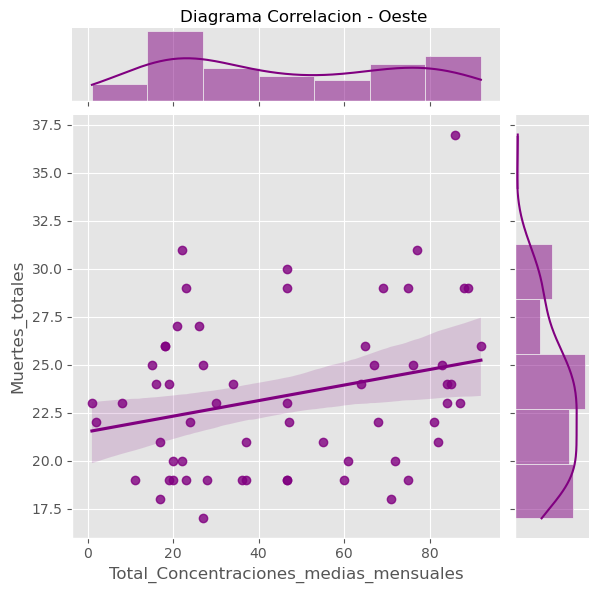

In [66]:
sns.jointplot(x='Total_Concentraciones_medias_mensuales',y='Muertes_totales',data=dataset_Oeste_wo2020,color='purple',kind='reg');
plt.suptitle("Diagrama Correlacion - Oeste")
plt.subplots_adjust(top=0.95) 

(0.0, 600.0)

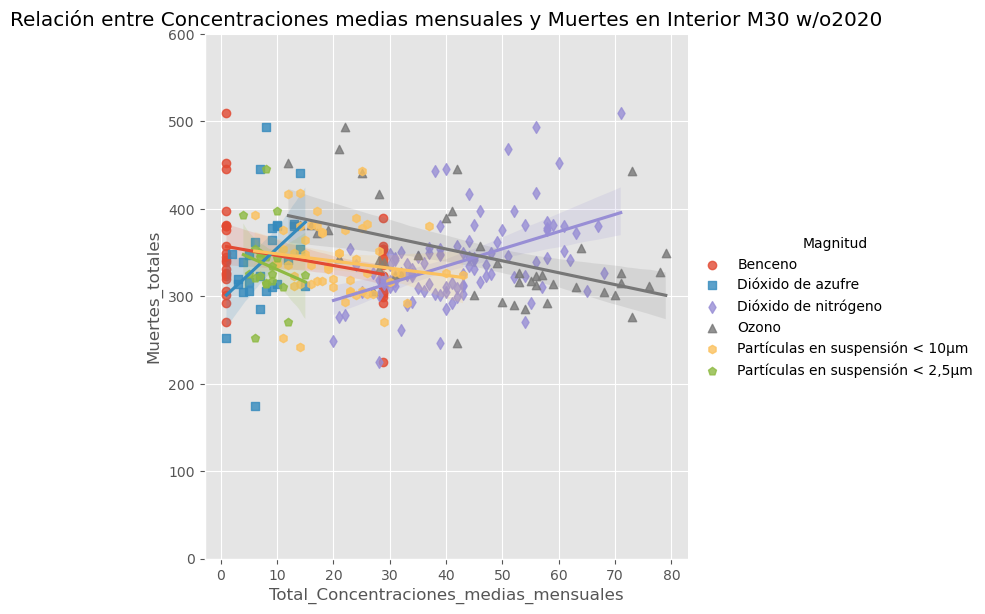

In [67]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_M30_wo2020, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Interior M30 w/o2020')
plt.ylim(0, 600)

(0.0, 40.0)

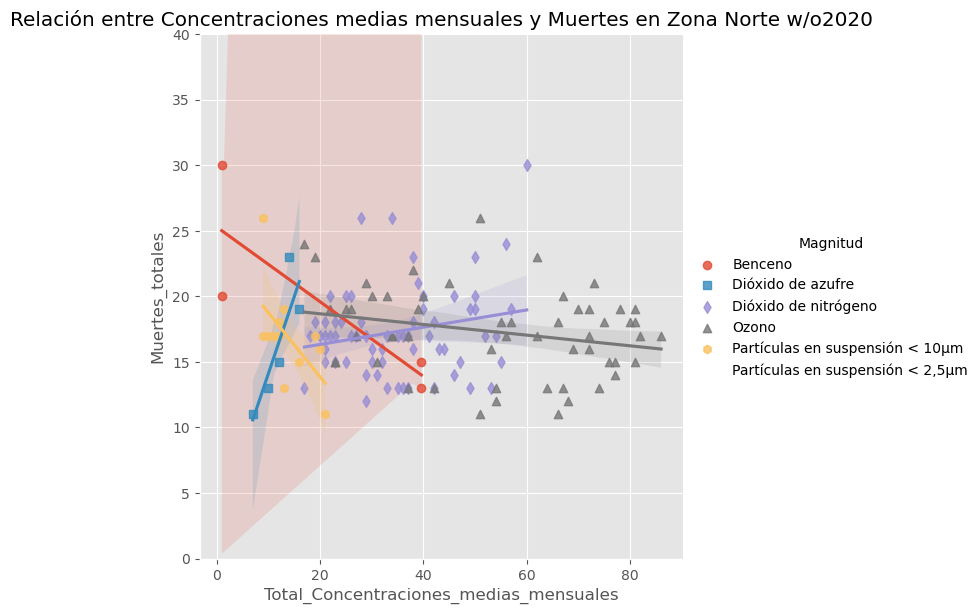

In [68]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Norte_wo2020, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Norte w/o2020')
plt.ylim(0, 40)

(0.0, 150.0)

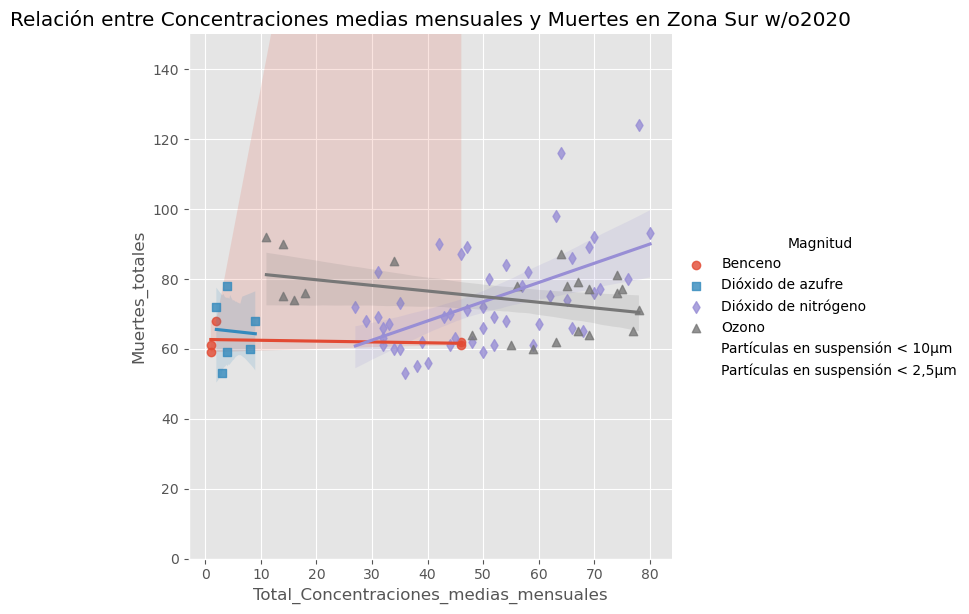

In [69]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Sur_wo2020, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Sur w/o2020')
plt.ylim(0, 150)

(0.0, 60.0)

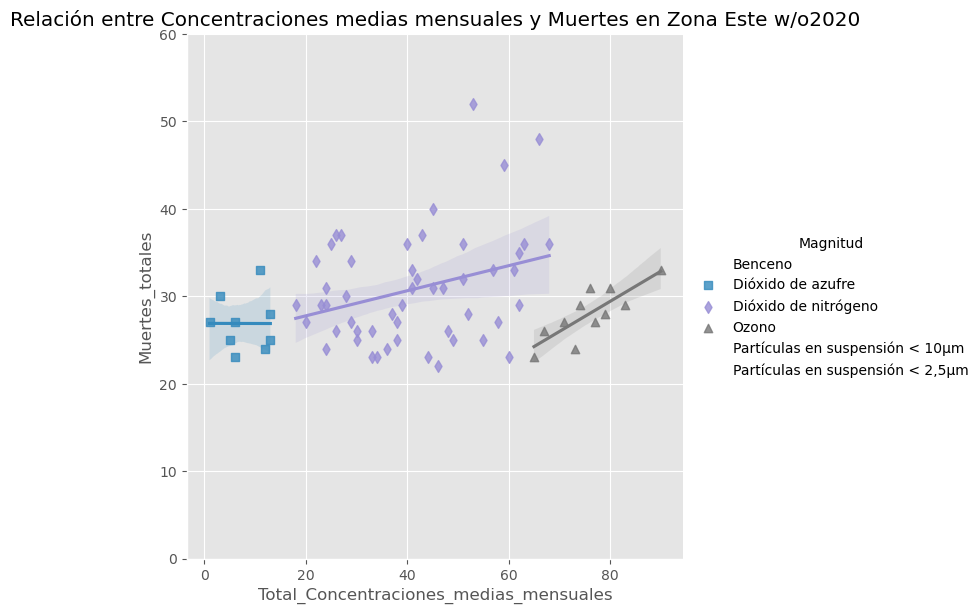

In [70]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Este_wo2020, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Este w/o2020')
plt.ylim(0, 60)

(0.0, 50.0)

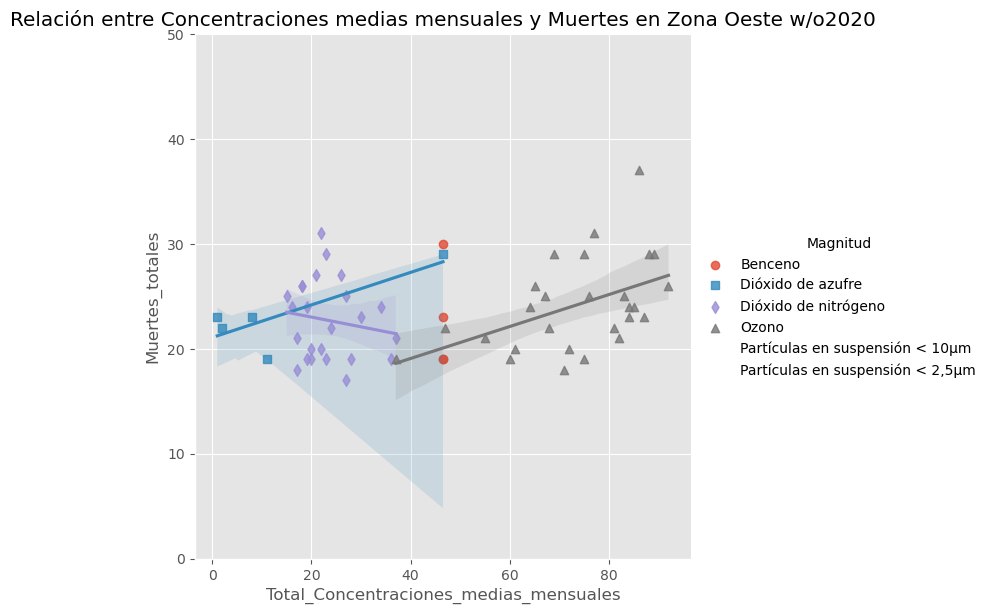

In [71]:
sns.lmplot(x='Total_Concentraciones_medias_mensuales', y='Muertes_totales', data=dataset_Oeste_wo2020, hue='Magnitud', markers=['o', 's','d' ,'^','h','p'], height=6)
plt.title('Relación entre Concentraciones medias mensuales y Muertes en Zona Oeste w/o2020')
plt.ylim(0, 50)

# Parte II. Modelo regresión lineal

In [ ]:
dataset_M30_wo2020_NO = dataset_M30_wo2020[dataset_M30_wo2020['Magnitud'] == 'Dióxido de nitrógeno']
dataset_M30_wo2020_NO.head()

In [77]:
X = dataset_M30_wo2020_NO['Total_Concentraciones_medias_mensuales']
y = dataset_M30_wo2020_NO['Muertes_totales']

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size= 0.8, random_state = 1, shuffle= True)

In [85]:

X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:        Muertes_totales   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     18.73
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           4.32e-05
Time:                        11:55:05   Log-Likelihood:                -424.72
No. Observations:                  82   AIC:                             853.4
Df Residuals:                      80   BIC:                             858.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [146]:
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
intervalos_ci

,2.5%,97.5%
const,222.319776,298.012564
Total_Concentraciones_medias_mensuales,0.997074,2.694488


In [148]:
predicciones = modelo.get_prediction(exog=X_train).summary_frame(alpha=0.05)
predicciones.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
300,324.768514,5.929233,312.968964,336.568063,237.382461,412.154567
302,321.076951,6.466057,308.209087,333.944815,233.540246,408.613657
185,359.838357,6.671691,346.561269,373.115446,272.240561,447.436154
247,345.072107,4.956503,335.208353,354.935862,257.926330,432.217885


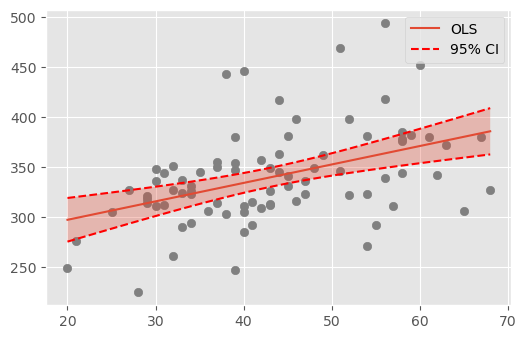

In [140]:
# Predicciones con intervalo de confianza del 95%
# ==============================================================================
predicciones = modelo.get_prediction(exog=X_train).summary_frame(alpha=0.05)
predicciones['x'] = X_train.loc[:, 'Total_Concentraciones_medias_mensuales']
predicciones['y'] = y_train
predicciones = predicciones.sort_values('x')

# Gráfico del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.3)
ax.legend();

In [134]:
# Error de test del modelo 
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 34.50808481502044


In [103]:
#ModeloRandomForest
modelRF = RandomForestRegressor(n_estimators=10, random_state=1,)
modelRF.fit(X_train, y_train)
preds_test= modelRF.predict(X_test)

In [105]:
print('MSE RandomFR : %.3f' % mean_squared_error(y_test, preds_test, squared=True))
print('MAE RandomFR  : %.3f' % mean_absolute_error(y_test, preds_test))

MSE RandomFR : 2225.843
MAE RandomFR  : 31.449


In [111]:
model = DecisionTreeClassifier(criterion='entropy', random_state=1)
model.fit(X_train, y_train)
predictions_model = model.predict(X_test)

In [119]:
print(accuracy_score(y_test, predictions_model))

0.0
